In [1]:
#Import libraries and load dataset
import pandas as pd #for data manipulation and analysis
import numpy as np # is used for numerical computations,
from sklearn.metrics.pairwise import cosine_similarity # to find similar recommendation
from sklearn.feature_extraction.text import CountVectorizer #preprocessing step in text-based machine learning models.
import matplotlib.pyplot as plt  # create plots, charts, and graphs.
import seaborn as sns  #high-level interface for creating attractive and informative statistical graphics.

ds1 = pd.read_csv('movies.csv')
ds2 = pd.read_csv('ratings.csv')


In [ ]:
ds1.info() #movies
ds1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


(10329, 3)

In [ ]:
ds2.info() #ratings
ds2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


(105339, 4)

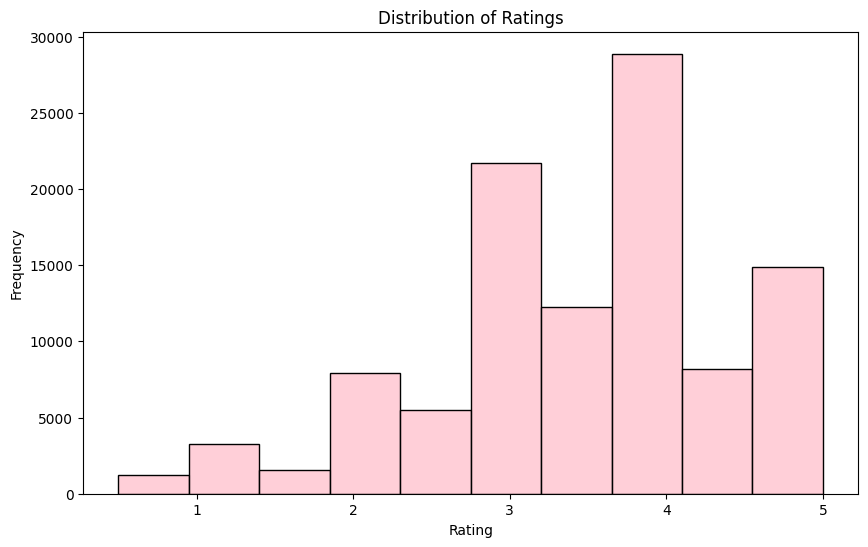

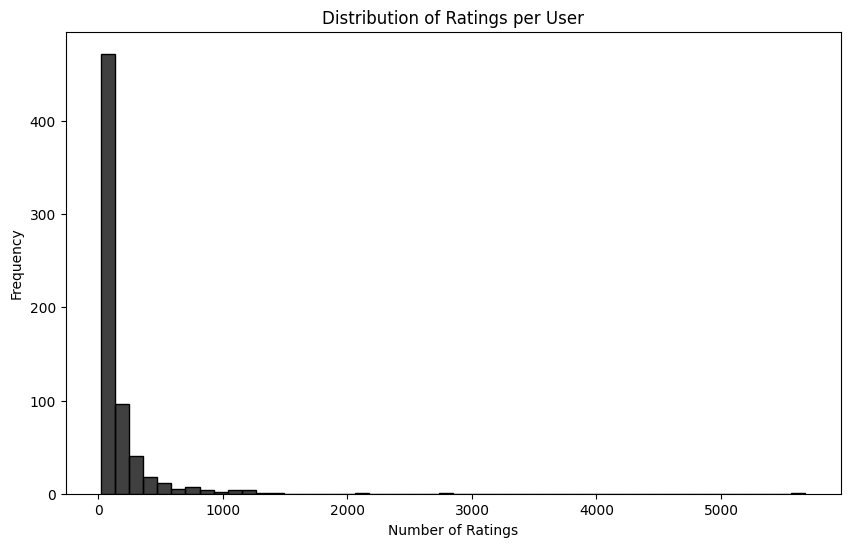

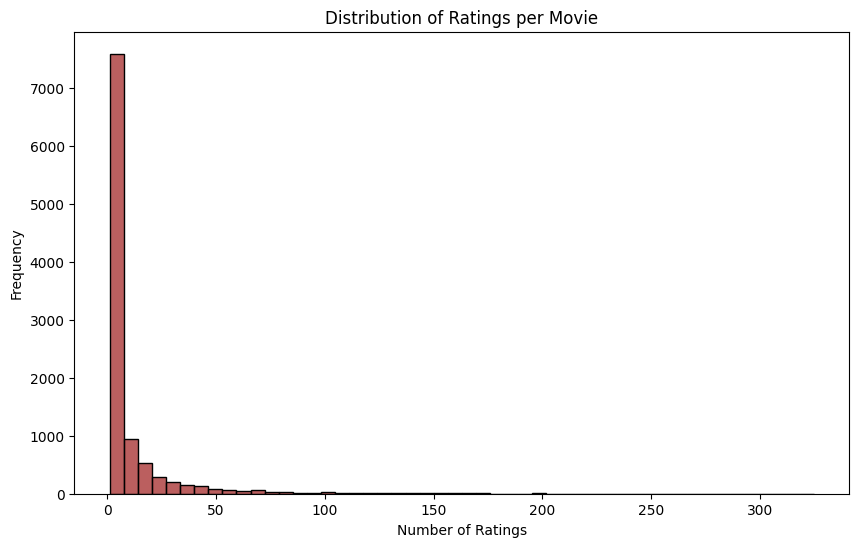

In [2]:
#Understanding of distribution of the features available
# Distribution of ratings
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(ds2['rating'], bins=10, kde=False, color='pink')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Distribution of number of ratings per user
ratings_per_user = ds2.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=False, color='black')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Distribution of number of ratings per movie
ratings_per_movie = ds2.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=False, color='brown')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


In [3]:
#Finding unique users and movies.

unique_users = ds2['userId'].nunique()
unique_movies = ds2['movieId'].nunique()

print(f"Unique Users: {unique_users}")
print(f"Unique Movies: {unique_movies}")


Unique Users: 668
Unique Movies: 10325


In [4]:
#Average rating and Total movies at genre level.
# Merge datasets
data = pd.merge(ds2, ds1, on='movieId')

# Explode genres (split pipe-separated genres into individual rows)
data['genres'] = data['genres'].str.split('|')
data = data.explode('genres')

# Average rating and total movies per genre
genre_stats = data.groupby('genres').agg(
    average_rating=('rating', 'mean'),
    total_movies=('movieId', 'nunique')
).reset_index()

print(genre_stats)


                genres  average_rating  total_movies
0   (no genres listed)        3.071429             7
1               Action        3.451450          1737
2            Adventure        3.518027          1164
3            Animation        3.635350           400
4             Children        3.439429           540
5               Comedy        3.420996          3513
6                Crime        3.642392          1440
7          Documentary        3.643035           415
8                Drama        3.650266          5218
9              Fantasy        3.500459           670
10           Film-Noir        3.913636           195
11              Horror        3.281097          1001
12                IMAX        3.641821           152
13             Musical        3.571962           409
14             Mystery        3.652043           675
15             Romance        3.544255          1788
16              Sci-Fi        3.454481           859
17            Thriller        3.495561        

In [5]:
#Unique genres considered
unique_genres = data['genres'].unique()
print(f"Unique Genres: {unique_genres}")


Unique Genres: ['Crime' 'Drama' 'Sci-Fi' 'Mystery' 'Thriller' 'Action' 'War' 'Adventure'
 'IMAX' 'Comedy' 'Romance' 'Western' 'Horror' 'Fantasy' 'Musical'
 'Film-Noir' 'Children' 'Animation' 'Documentary' '(no genres listed)']


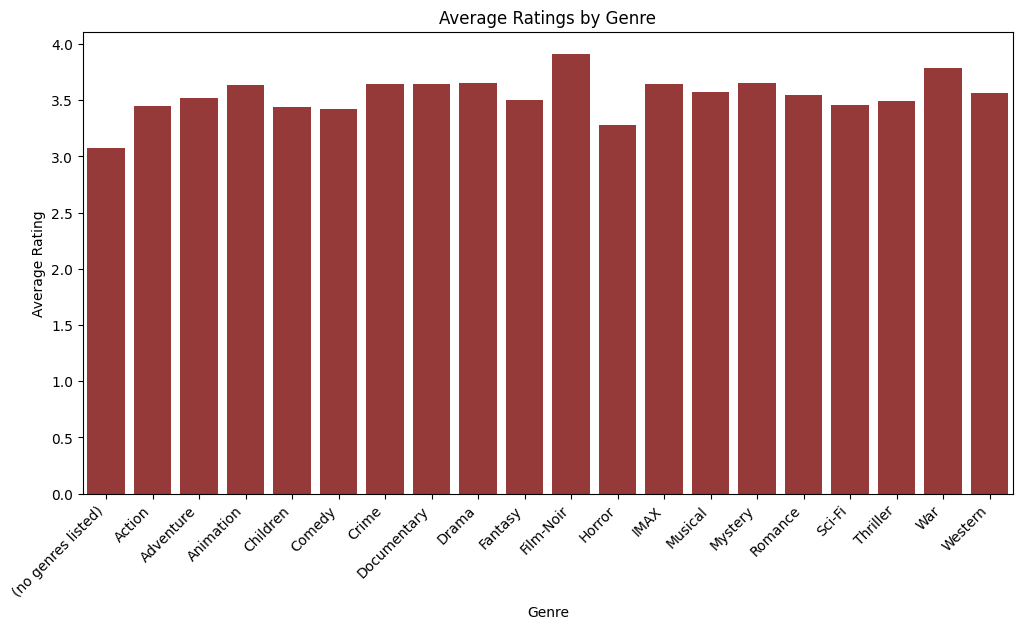

In [6]:
#Additional view of ratings
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats, x='genres', y='average_rating', color='brown')
plt.xticks(rotation=45, ha='right')
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()


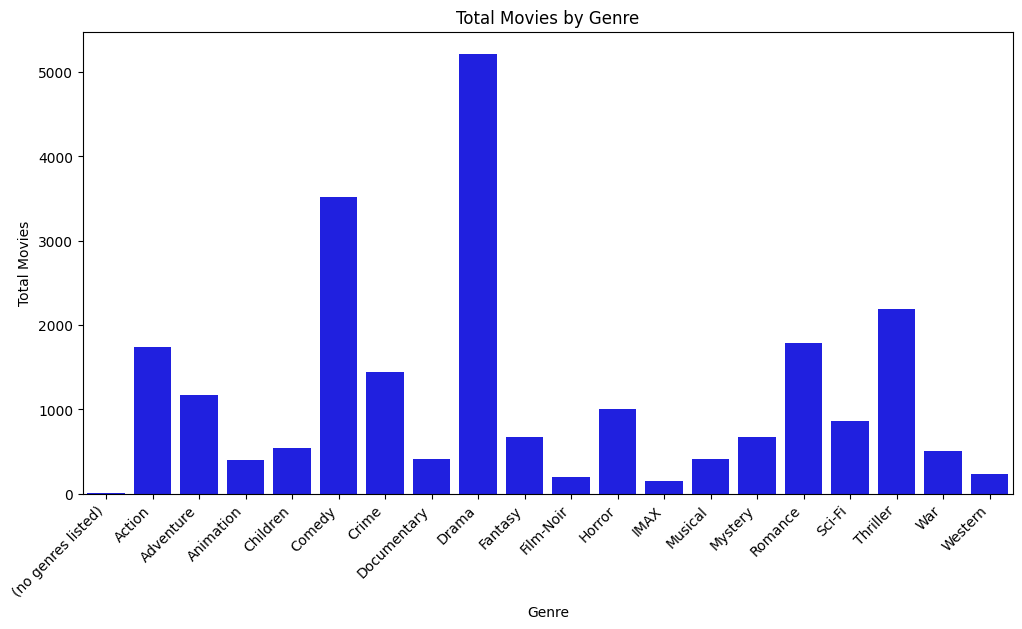

In [7]:
#Additional view of movies
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats, x='genres', y='total_movies', color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Total Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Movies')
plt.show()


In [16]:
# Design the 3 different types of recommendation modules as mentioned in objectives
# 1 Popularity based recommender system

def popularity_recommender(genre, min_reviews, num_recommendations):
    # Merge datasets
    data = pd.merge(ds2, ds1, on='movieId')

    # Filter by genre
    data['genres'] = data['genres'].str.split('|')
    data = data.explode('genres')
    genre_data = data[data['genres'].str.contains(genre, case=False, na=False)]

    # Group by movie and calculate stats
    aggregated = genre_data.groupby('title').agg(
        average_rating=('rating', 'mean'),
        num_reviews=('rating', 'count')
    ).reset_index()

    # Filter and sort
    filtered = aggregated[aggregated['num_reviews'] >= min_reviews]
    sorted_data = filtered.sort_values(by='average_rating', ascending=False)

    return sorted_data.head(num_recommendations)

# Example Usage
print(popularity_recommender('horror', 100, 5))



                                title  average_rating  num_reviews
810  Silence of the Lambs, The (1991)        4.194828          290
26                      Aliens (1986)        4.146497          157
817           Sixth Sense, The (1999)        4.130890          191
23                       Alien (1979)        4.064103          156
802               Shining, The (1980)        4.004464          112


In [9]:
# 2 Collaborative Filtering Recommender System

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

def collaborative_recommender(user_id, num_recommendations, num_similar_users):
    # Create user-item matrix
    data = pd.merge(ds2, ds1, on='movieId')
    user_item_matrix = data.pivot_table(index='userId', columns='title', values='rating').fillna(0)
    sparse_matrix = csr_matrix(user_item_matrix.values)

    # Compute similarity
    user_sim = cosine_similarity(sparse_matrix)
    similar_users = user_sim[user_id - 1].argsort()[-num_similar_users - 1:-1][::-1]

    # Aggregate ratings
    similar_user_ratings = user_item_matrix.iloc[similar_users].mean(axis=0)
    user_ratings = user_item_matrix.iloc[user_id - 1]
    recommendations = similar_user_ratings[user_ratings == 0].sort_values(ascending=False)

    return recommendations.head(num_recommendations)

# Example Usage
print(collaborative_recommender(11, 5, 100))



title
Fugitive, The (1993)                3.320
Forrest Gump (1994)                 3.320
Pulp Fiction (1994)                 3.180
Shawshank Redemption, The (1994)    2.915
Braveheart (1995)                   2.645
dtype: float64


In [10]:
# 3 Content-Based Recommender System

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def content_recommender(movie_title, num_recommendations):
    # Vectorize genres
    movies = pd.read_csv('movies.csv')
    movies['genres'] = movies['genres'].str.split('|')
    movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x))

    # Check if the movie title exists in the dataframe
    if movie_title not in movies['title'].values:
        print(f"Movie title '{movie_title}' not found in the dataset.")
        return pd.Series(dtype='object') # Return an empty Series if movie is not found

    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = count_vectorizer.fit_transform(movies['genres'])

    # Compute similarity
    cosine_sim = cosine_similarity(genre_matrix, genre_matrix)
    movie_idx = movies[movies['title'] == movie_title].index[0]
    similarity_scores = list(enumerate(cosine_sim[movie_idx]))

    # Sort and recommend
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # Exclude the movie itself from recommendations (the first score is always the movie itself)
    recommended_indices = [i[0] for i in sorted_scores[1:num_recommendations + 1]]

    return movies.iloc[recommended_indices]['title']

# Example Usage
# You might need to verify the exact title in your movies.csv
print(content_recommender('Toy Story (1995)', 5)) # Example: Using the full title with year if present

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1815                                       Antz (1998)
2496                                Toy Story 2 (1999)
2967    Adventures of Rocky and Bullwinkle, The (2000)
3166                  Emperor's New Groove, The (2000)
3811                             Monsters, Inc. (2001)
Name: title, dtype: object


In [17]:
#Additional/Optional: Create a GUI interface using Python libraries(ipywidgets etc.) to play around with the recommendation modules.

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Placeholder recommendation functions
def popularity_recommender(genre, min_reviews, num_recommendations):
    return pd.DataFrame({
        'Movie Title': ['Movie A', 'Movie B', 'Movie C', 'Movie D', 'Movie E'][:num_recommendations],
        'Average Rating': [4.5, 4.4, 4.3, 4.2, 4.1][:num_recommendations],
        'Number of Reviews': [500, 480, 470, 460, 450][:num_recommendations]
    })

def collaborative_recommender(user_id, num_recommendations, num_similar_users):
    return pd.DataFrame({
        'Movie Title': ['Movie F', 'Movie G', 'Movie H', 'Movie I', 'Movie J'][:num_recommendations],
        'Predicted Rating': [4.6, 4.5, 4.4, 4.3, 4.2][:num_recommendations]
    })

def content_recommender(movie_title, num_recommendations):
    return pd.DataFrame({
        'Movie Title': ['Movie K', 'Movie L', 'Movie M', 'Movie N', 'Movie O'][:num_recommendations],
        'Similarity Score': [0.95, 0.93, 0.92, 0.91, 0.90][:num_recommendations]
    })

# GUI interaction
def display_recommendations(_):
    clear_output(wait=True)
    display(ui)

    if recommender_type.value == "Popularity-Based":
        recommendations = popularity_recommender(genre.value, min_reviews.value, top_n.value)
    elif recommender_type.value == "Collaborative Filtering":
        recommendations = collaborative_recommender(user_id.value, top_n.value, similar_users.value)
    elif recommender_type.value == "Content-Based":
        recommendations = content_recommender(movie_title.value, top_n.value)
    else:
        recommendations = pd.DataFrame()  # Empty DataFrame for fallback

    print(f"Recommendations for {recommender_type.value}:")
    display(recommendations)

# Widgets
recommender_type = widgets.Dropdown(
    options=["Popularity-Based", "Collaborative Filtering", "Content-Based"],
    description="Type:"
)

genre = widgets.Text(description="Genre:")
min_reviews = widgets.IntSlider(value=50, min=10, max=500, step=10, description="Min Reviews:")
user_id = widgets.IntText(description="User ID:")
similar_users = widgets.IntSlider(value=50, min=10, max=500, step=10, description="Similar Users:")
movie_title = widgets.Text(description="Movie:")
top_n = widgets.IntSlider(value=5, min=1, max=20, step=1, description="Top N:")

button = widgets.Button(description="Get Recommendations")
button.on_click(display_recommendations)

# UI Layout
ui = widgets.VBox([
    recommender_type,
    widgets.HBox([genre, min_reviews]),
    widgets.HBox([user_id, similar_users]),
    widgets.HBox([movie_title]),
    top_n,
    button
])

# Initialize display
display(ui)


Recommendations for Popularity-Based:


,Movie Title,Average Rating,Number of Reviews
0,Movie A,4.5,500
1,Movie B,4.4,480
2,Movie C,4.3,470
3,Movie D,4.2,460
4,Movie E,4.1,450
